# Force Directed Graph Simulation
#### Authors: Shakeel Khan

This is the same implementation of a force directed graph that's used in the ProVis tab for the Graphitti Workbench.  It sets up a bunch of nodes in random locations, creating edges to form multiple groups of them and links the groups together. It then runs the force directed graph algorithm to space everything out (the simulation portion). Doing this allowed me to
 * Visualize data (e.g., net forces of the nodes throughout the simulation), so I could get a better understanding of how this algorithm works.
 * Understand why the current set of constants used in calculating the attractive and repelling forces don't work as exptected and have a way to find a proper set of constants.

At the end of the notebook is a Discussion covering most of the things mentioned here and my discoveries in finding a method to automatically detect when the nodes have been spaced out - that bit in partiuclar you should look at if you are trying to solve this issue. The notebook also explains the constants better than just calling them C1-C4.

[Here](https://cs.brown.edu/people/rtamassi/gdhandbook/chapters/force-directed.pdf) is a chapter from some textbook describing the algorithm being used. Section 12.2 from page 3 to 4 is what you're looking for.

# The Simulation
And here is the code. First, our imports.

In [89]:
%matplotlib notebook
import matplotlib.pyplot as plt
from Graph import Graph, Node
from math import log, pow
import random
import numpy as np

Define the constants. These are the constants for the sim:

In [90]:
# Sim constant definitions.
NUM_STEPS = 250
NUM_NODES = 20        # Don't exceed 30.
NODES_PER_GROUP = 5

And these are the constants used in the calculations for the attractive and repelling forces between the nodes.

There is a comment for each that is *my* interpretation of them. This is because the paper itself just calls them C1-C4, and goes "here is a reccomended set of values" with no further explanation, and I figured it would be beneficial to understand the influence each these constants play in the calculation of these forces.

In [91]:
C1 = 2.0    # This is the strength of the attractive force.
C2 = 10.0   # This is the distance desired between nodes
C3 = 5.0    # This is the strength of the repelling force.
C4 = 0.5    # This is the effective speed of the nodes.

Now we define our graph, create the nodes, and the edges in between.

Here's a quick rundown of the `Graph` class for those of you who'd like to tinker with it.

# Working With the `Graph` Class
## Creating an Instance of the Class
You would do this the same way you would instantiate any class in Python. The constructor only takes one parameter: the size of the graph (i.e., how many nodes it contains).

```
graph = Graph(10)    # Creates a graph containing 10 nodes.
```

## Adding Nodes to the Graph
Here we'll go over how to (1) create a node, and (2) adding the newly created node to the graph.

### Creating a Node
Nodes are represented using a dataclass (similar to a struct in C++) named `Node` that is defined in `Graph.py`.

Creating an instance of this dataclass is similar to the process of creating an instance of a normal class. The `Node` dataclass takes 2 parameters: a label (i.e., the name of the node. e.g., `A`, `1`, `foobar` etc.), and the position of the node, a 2-element numpy array.

Here's an example:

```
# Define the label and position of the node.
label = 'A'
pos = np.array([x, y], dtype=np.double)

# Create the node.
node = Node(label = label, position = pos)
```

### Adding the Newly Created Node
To add the node to the graph, simply call the `addNode()` method on your instance of the `Graph` class, passing in the newly created `Node`.

```
graph.addNode(node)
```

Keep in mind in the code there's a list called `nodes` that contains all of the Nodes in the graph. It used for creating the edges between them. It also used by the sim so it can traverse all the nodes in the graph.

## Creating Edges Between Nodes
Finally, to create an edge between nodes, we simply call the `addEdge()` method on our instance of the `Graph` class, passing the IDs of the two nodes the edge will be connecting. Notice I say *IDs* and **not** *labels*. The node's ID is internal to the `Graph`, which doesn't use the label of the node. Luckily, getting the ID of a node to pass it to `addEdge()` is as simple as accessing the `id` data field of the `Node`.

Here's an example:

```
# Say A and B are two previously defined nodes.
graph.addEdge(A.id, B.id)
```

And that's all there is to using the Graph class! Now we define it for the sim.

In [92]:
# Now we define our graph.
graph = Graph(NUM_NODES)
nodes = []

# This is used to make sure the starting position of each node is unique.
def isUniquePos(pos):
    for node in nodes:
        if np.array_equal(pos, node.position):
            return False
    return True

# Create our nodes.
random.seed(a = 10)
for i in range(NUM_NODES):
    # Keep generating random positions till we get something unique.
    x = random.randrange(320, 340, 1)
    y = random.randrange(240, 260, 1)

    pos = np.array([x, y], dtype=np.double)
    while (not isUniquePos(pos)):
        pos[0] = random.randrange(320, 340, 1)
        pos[1] = random.randrange(240, 260, 1)

    # Create the label for the node.
    label = str(i)

    # If this is the 'leader' of a group (it's directly connected to all the
    # nodes in the group) add *** to the label to distinguish it from others.
    if (i % NODES_PER_GROUP == 0):
        label += '***'

    # Create the node, add it to our list and add it to the graph.
    # The ID will be assigned by the graph.
    node = Node(label = label, position = pos)
    nodes.append(node)
    graph.addNode(node)

# Create the edges.
# TODO: Clean this up to model groups which actually would appear in ProVis.
#       You have the Activity node with five entity nodes connected to it
#       and one Sofwtare Agent node connected to it. There is also a commit
#       node connected to the Software Agent node. This node (the commit
#       node) is connetced to the commit nodes of other groups (or sims).
#       I don't imagine much of a difference in the results of the sim, but
#       perhaps it's worth a shot, time permitting.
# TODO: Try to add a way to add other detached groups.
for i in range(0, NUM_NODES, NODES_PER_GROUP):
    if (i != 0 and i != NUM_NODES):
        graph.addEdge(nodes[i - NODES_PER_GROUP].id, nodes[i].id)
        print('***(' + str(i - NODES_PER_GROUP) + ', ' + str(i) + ')')
    stop = i + NODES_PER_GROUP
    if (stop > NUM_NODES):
        stop = NUM_NODES - i
    for j in range (i + 1, stop):
        graph.addEdge(nodes[i].id, nodes[j].id)
        print('(' + str(i) + ', ' + str(j) + ')')

# Revised edge creation method which has the commit node IN PROGRESS.
# for i in range(0, NUM_NODES, NODES_PER_GROUP):
#     # Create the commit node.


#     # If this isn't the first one, (i.e., node ID 0) create an edge between this commit
#     # node and the previous one.

#     # Create the software agent node and an edge between it and the commit node.

#     # Create the activity node and an edge between it and the software agent node.

#     # Create the 4 entity nodes and created edges between them and the activity node.

# This was originally here for debugging purposes when implementing the graph,
# and is no longer necessary.
# graph.print()

(0, 1)
(0, 2)
(0, 3)
(0, 4)
***(0, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
***(5, 10)
(10, 11)
(10, 12)
(10, 13)
(10, 14)
***(10, 15)
(15, 16)
(15, 17)
(15, 18)
(15, 19)


Plot the starting position of each node.

<IPython.core.display.Javascript object>


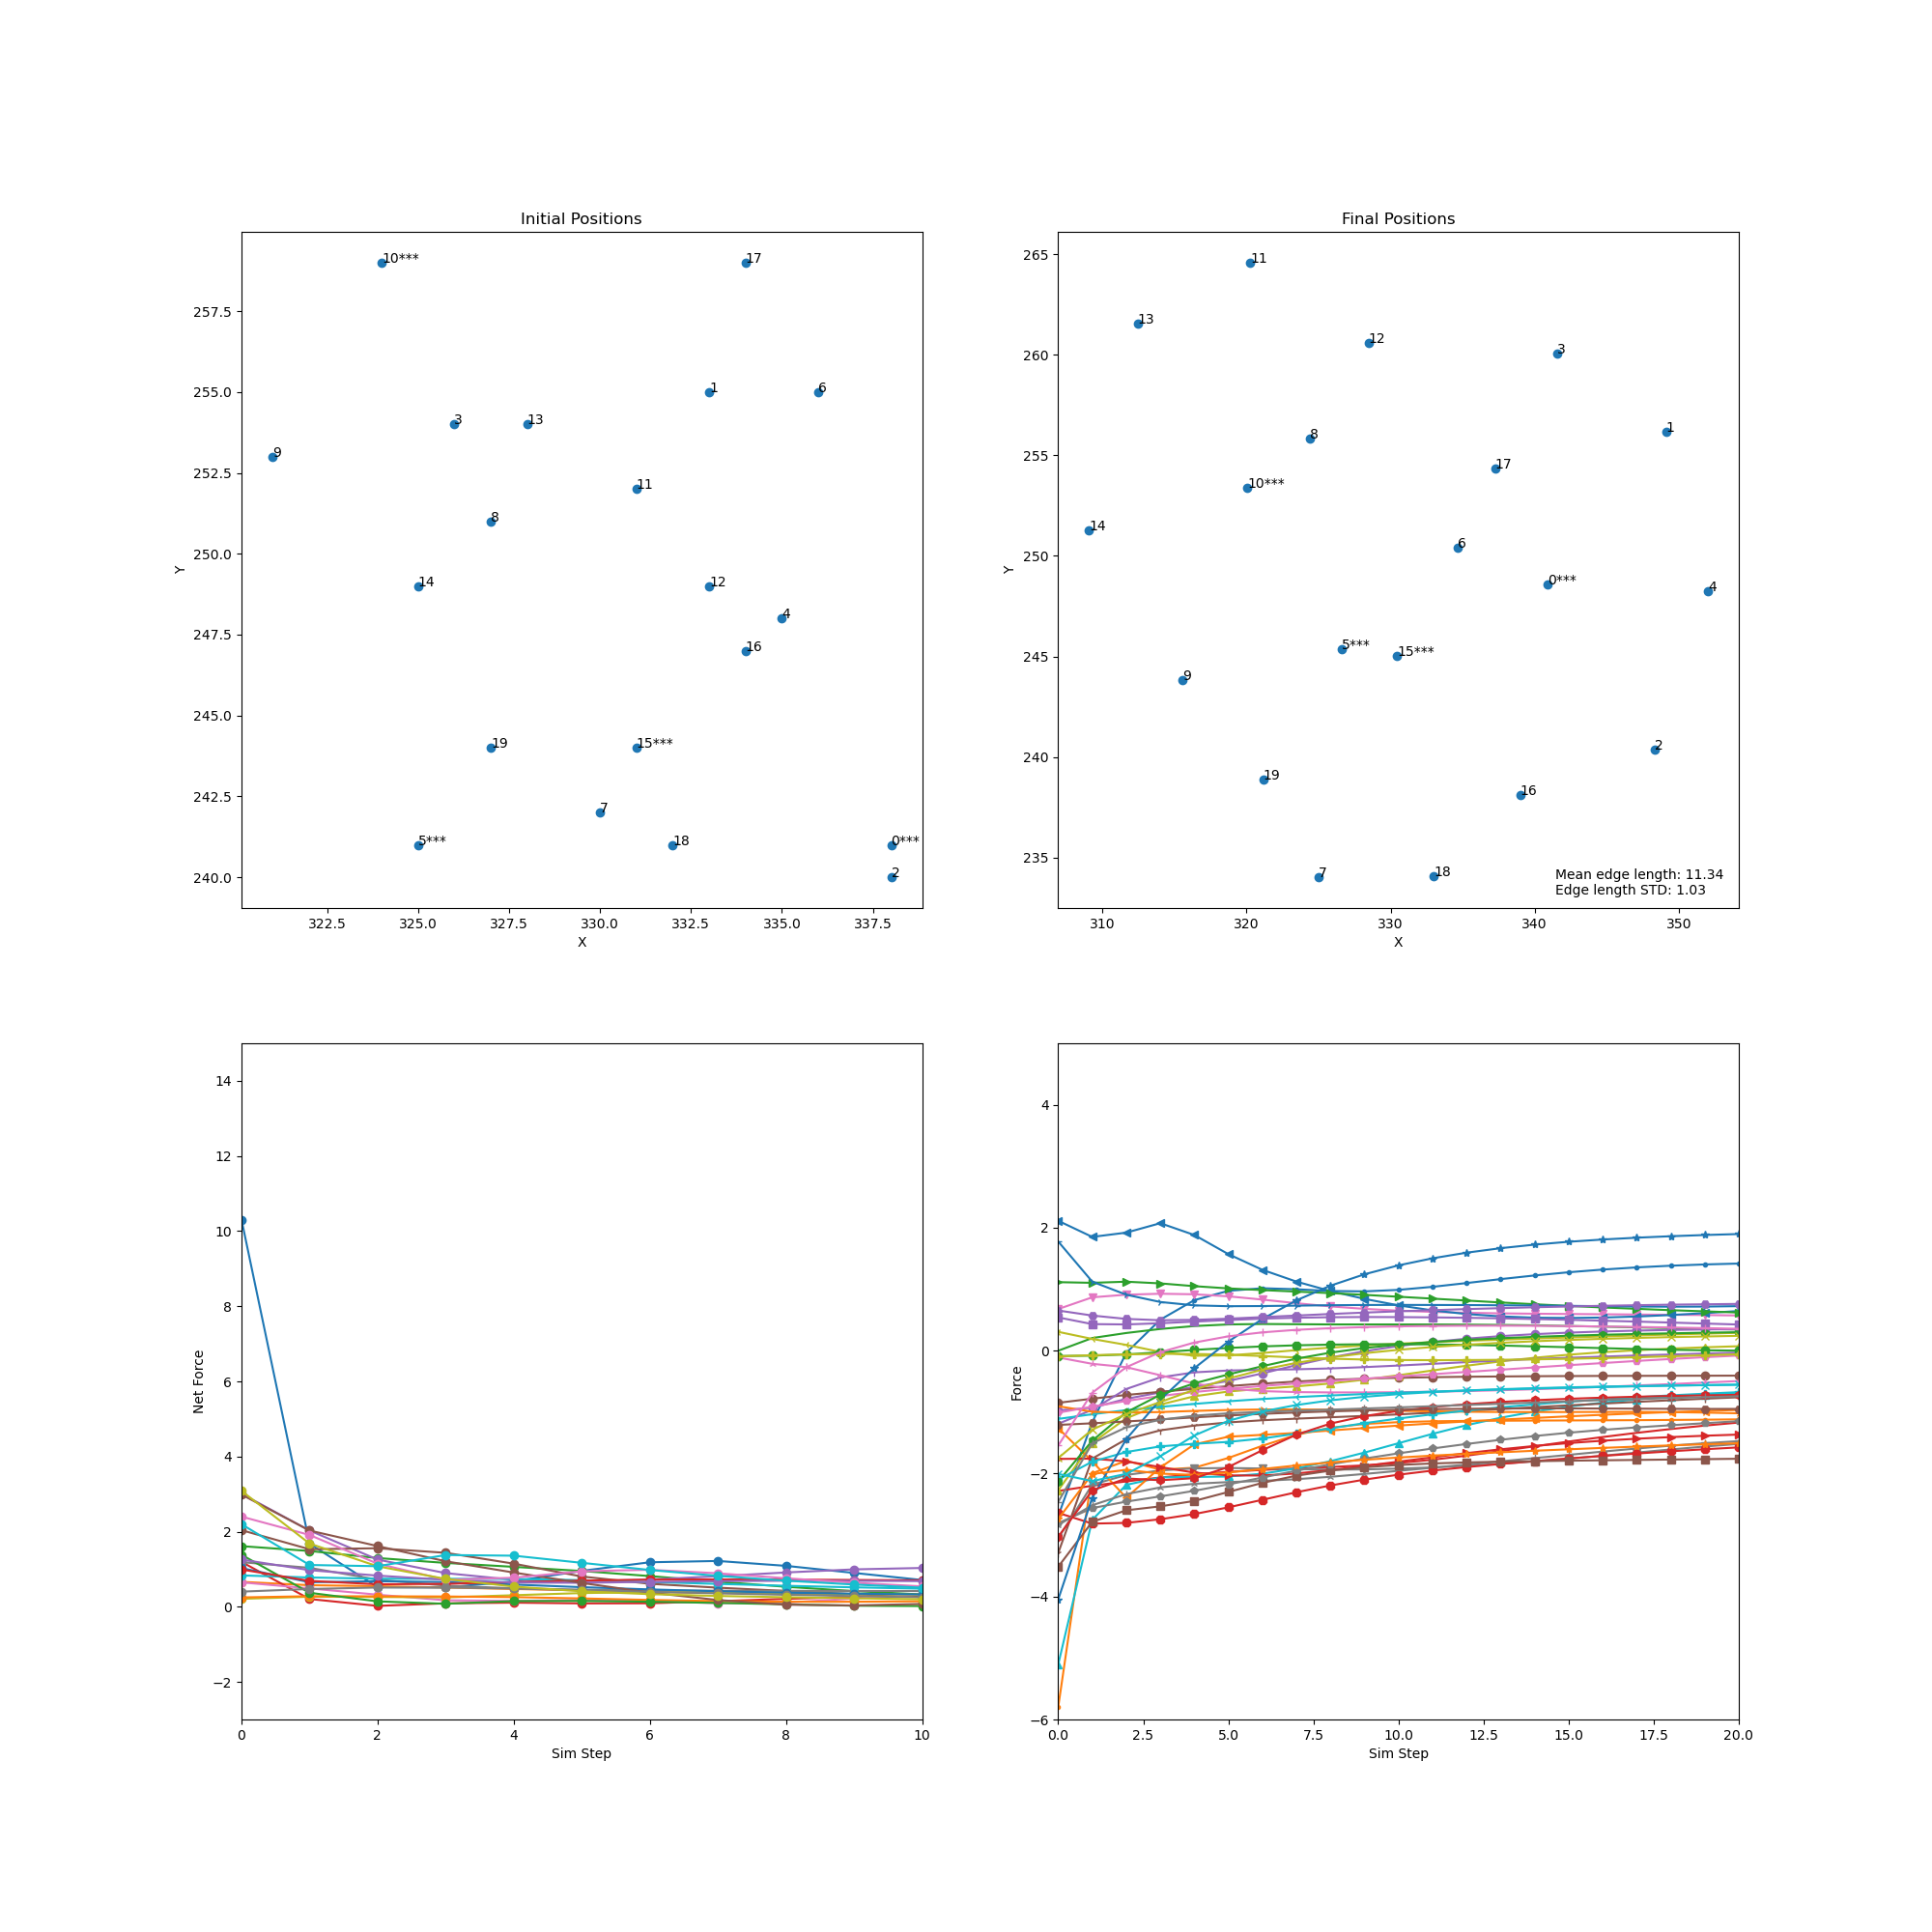

Text(0, 0.5, 'Y')

In [93]:
# This gets the X and Y values of the positions of all the nodes, as well as
# their labels, for when we want to plot their positions.
def getXY():
    x = []
    y = []
    labels = []

    for node in nodes:
        x.append(node.position[0])
        y.append(node.position[1])
        labels.append(node.label)

    return x, y, labels

# Graph the initial positions of the nodes.
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

x, y, labels = getXY()
axes[0][0].scatter(x, y)

for i, txt in enumerate(labels):
    axes[0][0].annotate(txt, (x[i], y[i]))

axes[0][0].set_title('Initial Positions')
axes[0][0].set_xlabel('X')
axes[0][0].set_ylabel('Y')

Define some helper methods for calculating the forces between nodes.

In [94]:
# Helper methods for calculating forces between the nodes.
def getDistance(src, dest):
    return np.linalg.norm(src - dest)

def normalizedVector(src, dest):
    return (dest - src) / np.linalg.norm(src - dest)

# These calculate the forces bewteen the nodes.
def attractiveForce(src, dest):
    # Calculate the distance and normalized vector of src and dest.
    distance = getDistance(src, dest)
    vec = normalizedVector(src, dest)
    
    # Calculate the attractive force and apply it.
    force = C1 * log(distance / C2)
    
    vec[0] = vec[0] * force
    vec[1] = vec[1] * force
    
    return vec, force

def repellingForce(src, dest):
    # Calculate the distance and normalized vector of src and dest.
    distance = getDistance(src, dest)
    vec = normalizedVector(src, dest)
    
    # Calculate the repelling force and apply it.
    force = -C3 / pow(distance, 2)
    
    vec[0] = vec[0] * force
    vec[1] = vec[1] * force
    
    return vec, force

Run the sim.

In [95]:
# Create the arrays to store our data in.
simX = np.array(range(NUM_STEPS), dtype = np.double)
attractiveForces = np.zeros((len(nodes), NUM_STEPS), dtype = np.double)
repellingForces = np.zeros((len(nodes), NUM_STEPS), dtype = np.double)
netForces = np.zeros((len(nodes), NUM_STEPS), dtype = np.double)
posX = np.zeros((len(nodes), NUM_STEPS), dtype = np.double)
posY = np.zeros((len(nodes), NUM_STEPS), dtype = np.double)

# Run the simulation.
for step in range(NUM_STEPS):
    for i, node1 in enumerate(nodes):
        netForce = np.array([0.0, 0.0], dtype = np.double)
        netAttractiveForce = 0.0
        netRepellingForce = 0.0
        for j, node2 in enumerate(nodes):
            if (node1 is not node2):
                if (graph.doesEdgeExist(node1.id, node2.id)):
                    # Compute the attractive and repelling forces.
                    pull, f_pull = attractiveForce(node1.position, node2.position)
                    push, f_push = repellingForce(node1.position, node2.position)

                    # Compute the net force on the node.
                    netForce[0] = netForce[0] + (pull[0] + push[0])
                    netForce[1] = netForce[1] + (pull[1] + push[1])
                    
                    # Keep track of the net attractive and repelling forces (for analysis).
                    netAttractiveForce = netAttractiveForce + f_pull
                    netRepellingForce = netRepellingForce + f_push
                else:
                    # Compute the repelling forces.
                    push, f_push = repellingForce(node1.position, node2.position)

                    # Compute the net force on the node.
                    netForce[0] = netForce[0] + push[0]
                    netForce[1] = netForce[1] + push[1]
                    
                    # Keep track of the net repelling force (for analysis).
                    netRepellingForce = netRepellingForce + f_push

        # Finally, we apply the force on the node by updating its position.
        netForces[i][step] = np.linalg.norm(netForce)
        node1.position[0] = node1.position[0] + (C4 * netForce[0])
        node1.position[1] = node1.position[1] + (C4 * netForce[1])
        
        # Save our data.
        posX[i][step] = node1.position[0]
        posY[i][step] = node1.position[1]
        
        attractiveForces[i][step] = netAttractiveForce
        repellingForces[i][step] = netRepellingForce

Graph the final positions of the nodes.

In [96]:
# Graph the final positions of the nodes.
x, y, labels = getXY()
axes[0][1].scatter(x, y)

for i, txt in enumerate(labels):
    axes[0][1].annotate(txt, (x[i], y[i]))

axes[0][1].set_title('Final Positions')
axes[0][1].set_xlabel('X')
axes[0][1].set_ylabel('Y')

Text(0, 0.5, 'Y')

Perform some post analysis of the final positions of the nodes and graph the net force of each node throughout the course of the simulation.

In [97]:
# Post analysis of node positions.
edgeLengths = []
for node1 in nodes:
    for node2 in nodes:
        if ((node1 is not node2) and graph.doesEdgeExist(node1.id, node2.id)):
            edgeLengths.append(getDistance(node1.position, node2.position))

data = np.array(edgeLengths, dtype=np.double)

# Calculate mean and standard deviation.
meanEdgeLength = np.mean(data)
edgeLengthStd = np.std(data)

results = f'Mean edge length: {round(meanEdgeLength, 2)}\nEdge length STD: {round(edgeLengthStd, 2)}'
axes[0][1].text(0.73, 0.02, results, size = 10, transform = axes[0][1].transAxes)

print('Mean edge length: ' + str(round(meanEdgeLength, 2)))
print('Edge length STD: ' + str(round(edgeLengthStd, 2)))

# TODO: Make a separate figure for drawing all the forces, do one per node
#       (showing attractive, repelling, and net forces).
# Graph the net forces of each node.
avgNetForce = 0
for i in range(NUM_NODES):
    label = "Node " + str(i) + " Net"
    axes[1][0].plot(simX, netForces[i], label = label, marker = 'o')
    avgNetForce += netForces[i][NUM_STEPS - 1]

axes[1][0].axis(xmin = 0, xmax = 10)
axes[1][0].axis(ymin = -3, ymax = 15)
axes[1][0].set_xlabel('Sim Step')
axes[1][0].set_ylabel('Net Force')

avgNetForce /= NUM_STEPS

print('Mean final net force: ' + str(round(avgNetForce, 2)))

Mean edge length: 11.34
Edge length STD: 1.03
Mean final net force: 0.0


Graph the attractive and repelling forces of each node throughout the simulation. Honestly, this graph is difficult to read and probably not very useful now; it was originally made because some of the figures were off (e.g., some nodes ended up with a positive attractive and repelling force), and I needed a way to check that.

In [98]:
# Graph the attractive and repelling forces of each node.
MARKERS = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

for i in range(NUM_NODES):
    label = "Node " + str(i) + " Attractive"
    axes[1][1].plot(simX, attractiveForces[i], label = label, marker = MARKERS[i])

    label = "Node " + str(i) + " Repelling"
    axes[1][1].plot(simX, repellingForces[i], label = label, marker = MARKERS[i])

axes[1][1].axis(xmin = 0, xmax = 20)
axes[1][1].axis(ymin = -6, ymax = 5)
axes[1][1].set_xlabel('Sim Step')
axes[1][1].set_ylabel('Force')

Text(0, 0.5, 'Force')

Finally, save the figure. It's never displayed, as I found viewing it through an image viewer better than using Matplotlib's built-in tools. But you should be able to display it in this notebook.

In [99]:
plt.savefig('results.png', dpi = 300)

# Discussion
I'm going to be covering how we can (possibly) automatically detect when the nodes have spaced out, and how to determine the right set of constants to use for C1-C4 in ProVis.
 
## Automatically Detecting When the Nodes are Spaced Out
### Analysis
According to the book chapter I linked at the beginning of this notebook, the criteria for an "aesthetically pleasing graph" for this algorithm is that (1) the lengths of the edges ought to be the same, and (2) the layout should display as much symmetry as possible.
 
For the first bit, I originally thought I could monitor the standard deviation and mean of the lengths of edges between nodes, expecting the former to gradually approach 0 and the latter to gradually approach the value of C2.

However, this doesn't quite work out. Using 20 nodes with 5 nodes per group and the values 2, 10, 5, and 1 for constants C1-C4 respectively, I ran the sim twice, one doing 100 steps and the other doing 250 steps. The standard deviation and mean of the lengths of edges between nodes were pretty much the same. However, when you look at the resulting graph, the one that took 100 steps was still very scattered and possessed little to no symmetry, while the one which took 250 steps looked nearly perfect and was far more symmetrical.

I also looked at the final net force of the nodes and in both cases, they were very close to each other (and pretty much 0). However, this difference was obviosuly substantial enough for the next 150 steps that the nodes continued to move, improving the symmetry of the graph. Also, by the time it reached 250 steps, the net force was so small that even after another 250 or 750 steps, the graph hardly changed.

### Further Exploration
So, there are two things to *maybe* explore:
 * Monitoring the average difference in position for the nodes between steps, specifically whether it gradually approaches 0. I just thought of this as I was writing this, so I have no idea whether it would work or not. But, it should be pretty quick to figure out.
 * Going off the second bit of what constitutes an "aesthetically pleasing graph", maybe we could find a way to monitor the graph's symmetry as it spaces out. I'm not really sure how to do this (or whether it's even possible).  1-2 minutes worth of Google searches returned some scary results (in terms of the math involved) and it's possible that performing this calculation is computationally intensive and not really worth it.

### A Possible Temporary (Perhaps Permanent) Solution
I think a simpler temporary solution is to just have the algorithm run for 500 steps every time the graph needs to be spaced out. Remember, with the current implementation in ProVis, what we call "steps" here is individual frames in the application. If the application is running at 30 FPS (JavaFX does whatever the system is capable of) it would take about 17 seconds for it to space out, at 60 FPS it's 9 seconds.

Or, you could perform the calculations on a separate thread, decoupling it from `AnimationTimer` which runs for every new frame. This could get the time down to a second or two. This also means it spaces out much faster for the user as well, possibly too fast. This can be solved by adding a delay between each step of the algorithm.

## Finding the Right Set of Constants
The only way to go about this is to guess and check. Maybe the constants used in the sim here are good (2, 10, 5, and 1 for C1-C4 respectively), however, the units here are kind of arbitrary so you may need to change C2 along with C1 and C3 accordingly. I mentioned this earlier, but the way I interpret the constants is:
 
 * `C1` - The strength of the attractive force.
 * `C2` - The distance desired between nodes.
 * `C3` - The strength of the repelling foce.
 * `C4` - The effective speed of the nodes.
 
Hopefully that can help in making more educated guesses when finding the right set of constants.

Somewhat related to this issue is the matter of detached nodes or detached groups of nodes, which will continue to drift away from each other.

The reason this is happening is because there is only a repelling force calculated between them. I haven't tested this due to time constraints, however my prediction is given the right set of constants even if you only calculate a repelling force for an unconnected node, the net force upon it should gradually go to 0.